<a id='Top'></a>

# Violation of proportional hazards<a class='tocSkip'></a>

Survival curves from Kaplan-Meier estimations and MultiSurv illustrating violation of proportional hazards.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler
import torch
from sklearn.decomposition import PCA
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

# Make modules in "src" dir visible
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(os.path.join(project_dir, 'src'))

import dataset
from model import Model
import utils

matplotlib.style.use('multisurv.mplstyle')

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MultiSurv-examples" data-toc-modified-id="MultiSurv-examples-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MultiSurv examples</a></span><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model-predictions" data-toc-modified-id="Model-predictions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model predictions</a></span></li><li><span><a href="#Cancer-types" data-toc-modified-id="Cancer-types-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Cancer types</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li><li><span><a href="#Individual-patients" data-toc-modified-id="Individual-patients-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Individual patients</a></span><ul class="toc-item"><li><span><a href="#Save-to-file" data-toc-modified-id="Save-to-file-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Save to file</a></span></li></ul></li></ul></li><li><span><a href="#Scaled-Schoenfeld-residuals-test" data-toc-modified-id="Scaled-Schoenfeld-residuals-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scaled Schoenfeld residuals test</a></span><ul class="toc-item"><li><span><a href="#Clinical-data" data-toc-modified-id="Clinical-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clinical data</a></span></li><li><span><a href="#mRNA" data-toc-modified-id="mRNA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>mRNA</a></span></li><li><span><a href="#DNAm" data-toc-modified-id="DNAm-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>DNAm</a></span></li><li><span><a href="#miRNA" data-toc-modified-id="miRNA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>miRNA</a></span></li><li><span><a href="#CNV" data-toc-modified-id="CNV-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>CNV</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
PLOT_SIZE = (3.75, 2.5)
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# MultiSurv examples

## `DataLoader`

In [4]:
dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=['clinical', 'mRNA'],
#     exclude_patients=exclude_cancers,
    return_patient_id=True
)

Data modalities:
   clinical
   mRNA

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


## Model predictions

Collect model predictions for all patients in the test dataset.

In [5]:
multisurv = Model(dataloaders=dataloaders, device=device)
multisurv.load_weights(os.path.join(MODELS, 'clinical_mRNA_lr0.005_epoch43_acc0.81.pth'))

Instantiating MultiSurv model...
Load model weights:
/mnt/dataA/multisurv_models/clinical_mRNA_lr0.005_epoch43_acc0.81.pth


In [6]:
patient_dataset = dataloaders['test'].dataset

In [7]:
%%time

results = multisurv.predict_dataset(patient_dataset)
print()
print()

Analyzing patients
1092/1092

CPU times: user 33.5 s, sys: 7.9 s, total: 41.4 s
Wall time: 1min 39s


In [8]:
def predictions_to_pandas(data):
    labels = pd.read_csv('../data/labels.tsv', sep='\t')
    predictions = np.stack([x[0] for x in data['patient_data'].values()])    
    # Add prediction 1 at time 0 (patients still alive)
    ones = np.ones((predictions.shape[0], 1))
    predictions = np.concatenate((ones, predictions), axis=1)
    
    predictions = pd.DataFrame(predictions, columns=[str(i) for i in range(predictions.shape[-1])])
    patient_ids = list(data['patient_data'].keys())
    predictions['submitter_id'] = patient_ids
    
    predictions = predictions.merge(labels.iloc[:, :-1])
    predictions.set_index('submitter_id', inplace=True)
    
    return predictions

In [9]:
predictions = predictions_to_pandas(data=results)

## Cancer types

In [10]:
def get_KM_estimates(data, return_kmfitter=False):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=data['time'].values,
            event_observed=data['event'].values)

    if return_kmfitter:
        return kmf

    x = kmf.survival_function_.index.values
    y = kmf.survival_function_
    
    return x, y

In [11]:
def plot_selected_cancer_type_survival(data, cancer_type_cm, time_points,
                                       plot_size=PLOT_SIZE, n_time_points=22):
    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    for cancer_type in cancer_type_cm:
        cancer_data = data[data['project_id'] == cancer_type]
        x, y = get_KM_estimates(cancer_data)
        ax.plot(x, y, '--', color=cancer_type_cm[cancer_type], label=cancer_type)
        
        mean_probabilities = cancer_data[[str(i) for i in range(len(time_points))]].mean(axis=0).values
        ax.plot(time_points[:n_time_points], mean_probabilities[:n_time_points], 'o-',
                color=cancer_type_cm[cancer_type], label=cancer_type)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, n_time_points)
    legend_elements = custom_legend_for_group_survival_plot(
        colors=cancer_type_cm, groups=cancer_type_cm.keys())
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')

    return fig

In [12]:
def custom_legend_for_group_survival_plot(colors, groups):
    # Color
    legend_elements = []
    for group in groups:
        legend_elements.append(matplotlib.patches.Patch(
            facecolor=colors[group], edgecolor=colors[group],
            linewidth=3, label=group))

    # Line style
    markers, line_styles = ['', 'o'], ['--', '-']
    for i, x in enumerate(['Kaplan-Meier', 'MultiSurv']):
        legend_elements.append(matplotlib.lines.Line2D(
            [0], [0], color='k', marker=markers[i], ls=line_styles[i], label=x))

    return legend_elements

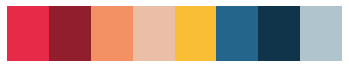

In [13]:
utils.plot.show_default_colors()

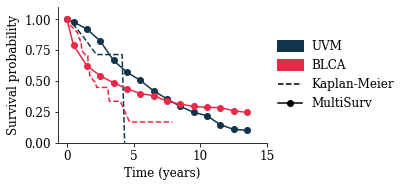

In [15]:
survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

cancer_type_colors = {
    'UVM': default_colors[6],
    'BLCA': default_colors[0],
}

fig = plot_selected_cancer_type_survival(
    data=predictions,
    cancer_type_cm=cancer_type_colors,
    time_points=survival_time_points,
    n_time_points=15)

### Save to file

## Individual patients

In [16]:
def custom_legend_for_patient_plot(label_color_map):
    legend_elements = []

    for k in label_color_map:
        if k != 'Other patients':
            marker, alpha = 'o', 1
        else:
            marker, alpha = '', 0.15

        legend_elements.append(matplotlib.lines.Line2D(
            [0], [0], color=label_color_map[k], marker=marker, alpha=alpha, label=k))

    return legend_elements

In [17]:
def annotate_follow_up_time(ax, annotation_map, patient_color):
    text = annotation_map['text']
    xy = (annotation_map['time_point'],
          annotation_map['probability'])
    nudge = annotation_map['nudge']
    text_coords = (annotation_map['time_point'] + nudge[0],
                   annotation_map['probability'] + nudge[1])

    ax.annotate(text, xy=xy, xytext=text_coords,
                color=patient_color,
                bbox=dict(boxstyle='round,pad=0.1', fc='w', ec='w', alpha=0.5),
                arrowprops=dict(arrowstyle='-', color=patient_color))

    return ax

In [18]:
def plot_two_patient_survival(data, selected_patient_cm, time_points,
                              follow_up_annotations=None, plot_size=PLOT_SIZE,
                              n_time_points=15):

    fig = plt.figure(figsize=plot_size)
    ax = fig.add_subplot(1, 1, 1)

    for patient in selected_patient_cm:
        probabilities = data.loc[patient][[str(i) for i in range(len(time_points))]].values
        ax.plot(time_points[:n_time_points], probabilities[:n_time_points],
                marker='o', color=selected_patient_cm[patient], label=patient)

        ax = annotate_follow_up_time(ax, follow_up_annotations[patient],
                                     patient_color=selected_patient_cm[patient])

    ax.set_ylim(0, 1.1)
    ax.set_xlim(None, n_time_points)
    legend_elements = custom_legend_for_patient_plot(label_color_map=selected_patient_cm)
    ax.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title('')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Survival probability')

    return fig

__Patient details:__

* __TCGA-2L-AAQM:__ 52 year-old white male diagnosed with Pancreatic Adenocarcinoma (__PAAD__); __alive__ at last follow up 1,383 days after diagnosis;
* __TCGA-BH-A1EO:__ 68 year-old white female diagnosed with Breast Invasive Carcinoma (__BRCA__); __dead__ 2,798 days after diagnosis.

(accessed by entering patient ID in the search box at [GDC Data Portal](https://portal.gdc.cancer.gov/))

In [19]:
selected_patients = ['TCGA-2L-AAQM', 'TCGA-BH-A1EO']

In [20]:
colors = [default_colors[c] for c in [0, 6]]
selected_patient_colors = {p: colors[i] for i, p in enumerate(selected_patients)}

In [21]:
predictions.loc[selected_patients, ['project_id', 'time', 'event']]

,project_id,time,event
submitter_id,,,
TCGA-2L-AAQM,PAAD,3.789041,0
TCGA-BH-A1EO,BRCA,7.665753,1


In [22]:
nudges = {selected_patients[0]: (0, 0.2),
          selected_patients[1]: (-2, -0.25)}

annotation_text = {}

for patient in selected_patients:
    annot = 'Death' if predictions.loc[patient]['event'] else 'Last follow up'
    annotation_text[patient] = annot

follow_up_annotation_map = {}

for patient in selected_patients:
    follow_up_annotation_map[patient] = {
        'time_point': predictions.loc[patient]['time'],
        'probability': multisurv.predict(
            input_data=patient_dataset.get_patient_data(patient)[0],
            prediction_year=predictions.loc[patient]['time'])[1],
        'nudge': nudges[patient],
        'text': annotation_text[patient]}

survival_time_points = utils.plot.format_output_intervals(multisurv.output_intervals)

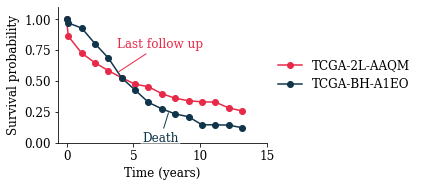

In [23]:
fig = plot_two_patient_survival(
    data=predictions, selected_patient_cm=selected_patient_colors,
    time_points=survival_time_points, follow_up_annotations=follow_up_annotation_map,
    plot_size=PLOT_SIZE, n_time_points=15)

### Save to file

#  Scaled Schoenfeld residuals test

Run scaled Schoenfeld residual tests to check whether input features violate the proportional hazards assumption. Use the implementation in the `lifelines` library, which is based on [Park and Hendry, 2015](https://onlinelibrary.wiley.com/doi/abs/10.1111/ajps.12176), as explained in the [online documentation](https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html).

In [24]:
def dataset_to_df(pytorch_dataset, modality):   
    data_dict = {'time': [],
                 'event': [],
                 'patient_id': []}
    
    n_vars = {
#         'clinical': 15,
        'clinical': 10,
        'mRNA': 1000,
        'miRNA': 1881,
        'DNAm': 5000,
        'CNV': 2000
    }

    for i in range(n_vars[modality]):
        data_dict[str(i)] = []
    
    for i, patient_data in enumerate(pytorch_dataset):
        data, time, event, pid = patient_data
        print('\r' + f'Load all patient data: {str((i + 1))}/{len(pytorch_dataset)}    ',
              end='')
        
        data_dict['time'].append(time)
        data_dict['event'].append(event)
        data_dict['patient_id'].append(pid)
        
        if modality == 'clinical':
            for j, x in enumerate(data[modality][0]):
                data_dict[str(j)].append(int(x))

            for x in data[modality][1]:
                j += 1
                data_dict[str(j)].append(round(float(x), 6))
        elif modality == 'CNV':
            for j, x in enumerate(data[modality]):
                data_dict[str(j)].append(int(x))
        else:
            for j, x in enumerate(data[modality]):
                data_dict[str(j)].append(round(float(x), 6))
    print()
            
    df = pd.DataFrame.from_dict(data_dict)
    df.set_index('patient_id', inplace=True)
    
    return df

## Clinical data

In [25]:
modality = 'clinical'
# modality = 'mRNA'

dataloaders = utils.get_dataloaders(
    data_location=DATA,
    labels_file='../data/labels.tsv',
    modalities=[modality],
    return_patient_id=True
)

Data modalities:
   clinical

Dataset sizes (# patients):
   train: 8880
   val: 1109
   test: 1092

Batch size: 128


In [26]:
%%time

clinical_data = dataset_to_df(pytorch_dataset=dataloaders['train'].dataset,
                              modality=modality)

print()
print()

Load all patient data: 8880/8880    


CPU times: user 1min 58s, sys: 30.4 s, total: 2min 28s
Wall time: 4min 56s


In [27]:
# One-hot encode categorical variables
cols = [str(x) for x in range(9)]

# Convert index to regular column
clinical_data.reset_index(level=['patient_id'], inplace=True)

data_dfs = pd.get_dummies(clinical_data, columns=cols, drop_first=True)

# Put index back
clinical_data.set_index('patient_id', inplace=True)

In [28]:
print(f'Fitting CPH model on {modality} data...')
print()

# Instantiate model
cph = CoxPHFitter()

# Fit model
cph.fit(clinical_data, duration_col='time', event_col='event',
        show_progress=False, step_size=1.0)
#         show_progress=False)

Fitting CPH model on clinical data...



<lifelines.CoxPHFitter: fitted with 8880 total observations, 6030 right-censored observations>

In [29]:
clinical_data.head()

,time,event,0,1,2,3,4,5,6,7,8,9
patient_id,,,,,,,,,,,,
TCGA-22-1000,1.243836,1,17,1,7,0,2,2,1,1,6,0.827934
TCGA-AP-A1E4,4.260274,0,30,0,7,0,1,0,2,2,2,0.548010
TCGA-BP-4968,4.783562,0,11,1,7,0,1,0,0,0,4,0.369297
TCGA-64-5778,3.575342,0,16,1,7,0,1,0,1,2,6,0.621149
TCGA-G4-6310,5.301370,0,5,1,7,0,2,2,2,2,13,0.735929


__Feature name correspondence:__

* __0:__ project ID (cancer type);
* __1:__ gender;
* __2:__ race;
* __3:__ prior treatment;
* __4:__ prior malignancy;
* __5:__ synchronous malignancy;
* __6:__ pharmaceutical treatment;
* __7:__ radiation treatment;
* __8:__ tumor stage;
* __9:__ age at diagnosis.

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable '2' failed the non-proportional test: p-value is 0.0013.

   Advice: with so few unique values (only 8), you can include `strata=['2', ...]` in the call in
`.fit`. See documentation in link [E] below.

2. Variable '4' failed the non-proportional test: p-value is 0.0026.

   Advice: with so few unique values (only 3), you can include `strata=['4', ...]` in the call in
`.fit`. See documentation in link [E] below.

3. Variable '6' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['6', ...]` in the call in
`.fit`. See documentation in link [E] below.

4. Variable '7' failed the non-proportional test: p-value is 0.0074.

   Advice: with so few unique values (only 3), you can include `strata=['7', ...]` in the call in
`.fit`. See documentation in link [E] below.

5. Variable '8' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable '8' might be incorrect.

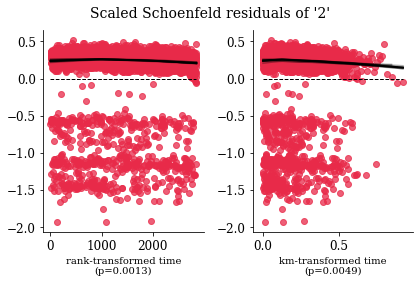

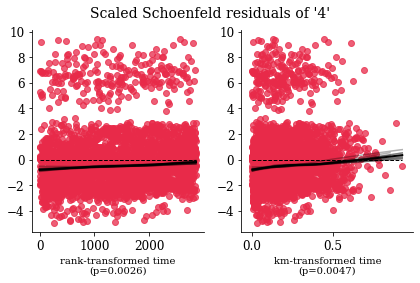

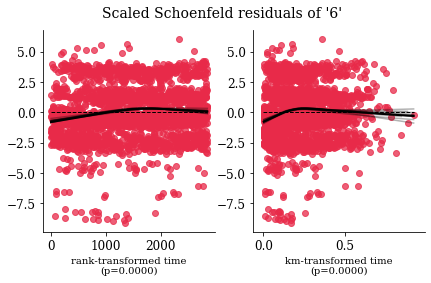

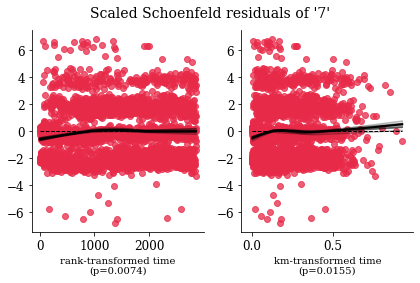

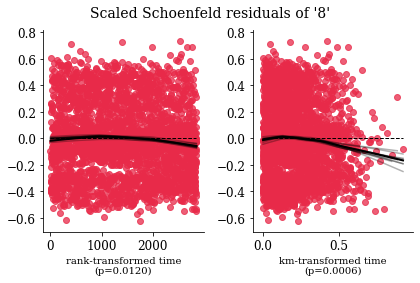

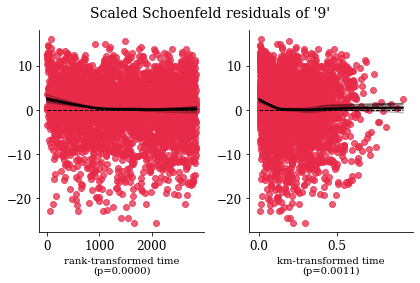

In [62]:
%%time

cph.check_assumptions(clinical_data, p_value_threshold=0.05, show_plots=True)

In [64]:
last_point_num_in_output = 6
print('Null hypothesis (no violation of proportional hazards) rejected for:')
print(f'{last_point_num_in_output} out of {len(cph.params_)} input features')

Null hypothesis (no violation of proportional hazards) rejected for:
6 out of 10 input features


##  mRNA

In [4]:
def fit_omics_cph(data_modality, data_dir=DATA):
    dataloaders = utils.get_dataloaders(
        data_location=data_dir,
        labels_file='../data/labels.tsv',
        modalities=[data_modality],
        return_patient_id=True
    )

    print()
    data = dataset_to_df(pytorch_dataset=dataloaders['train'].dataset,
                         modality=data_modality)
    print()

    # Too many input features for CPH; reduce dimensions
    pca_data = data.iloc[:, 2:]
    # Get components
    pca = PCA(n_components=50)
    pca_data = pca.fit_transform(pca_data)
    # Add labels back
    data = pd.concat([data.iloc[:, :2], pd.DataFrame(pca_data).set_index(data.index)], axis=1)

    print(f'Fitting CPH model on {data_modality} data...')
    print()

    # Instantiate model
    cph = CoxPHFitter()

    # Fit model
    cph.fit(data, duration_col='time', event_col='event',
            show_progress=False, step_size=1.0)
#             show_progress=False)

    return data, cph

In [7]:
%%time

modality = 'mRNA'

mRNA_data, cph = fit_omics_cph(modality)

Excluding 1188 patient(s) missing all data.
Excluding 153 patient(s) missing all data.
Excluding 135 patient(s) missing all data.
Data modalities:
   mRNA

Dataset sizes (# patients):
   train: 7692
   val: 956
   test: 957

Batch size: 128

Load all patient data: 7692/7692    

Fitting CPH model on mRNA data...

CPU times: user 1min 35s, sys: 16.5 s, total: 1min 51s
Wall time: 1min 44s


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable '0' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable '0' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '0' using pd.cut, and then specify it in `strata=['0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable '1' failed the non-proportional test: p-value is 0.0012.

   Advice 1: the functional form of the variable '1' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the var

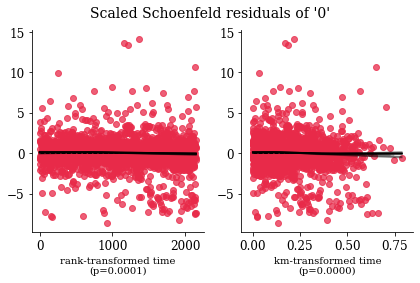

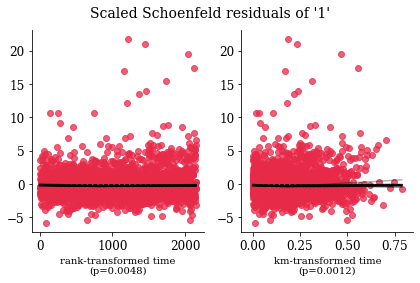

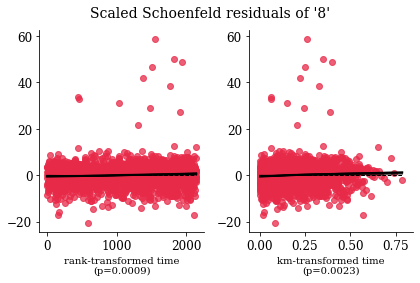

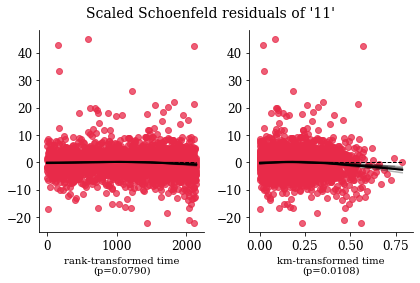

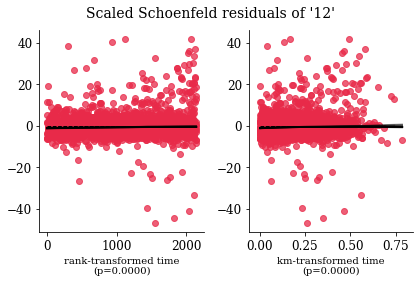

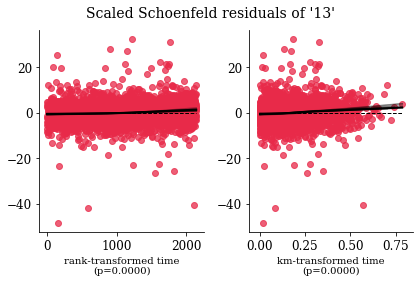

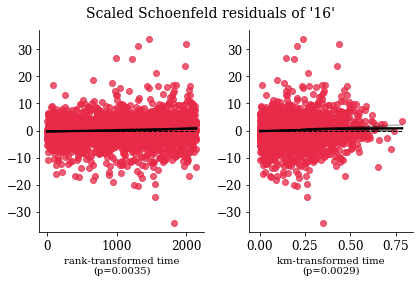

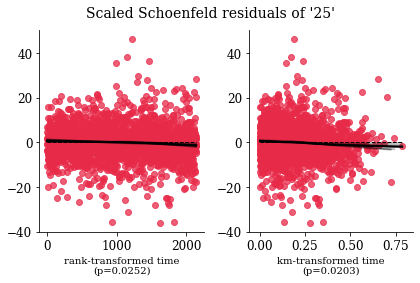

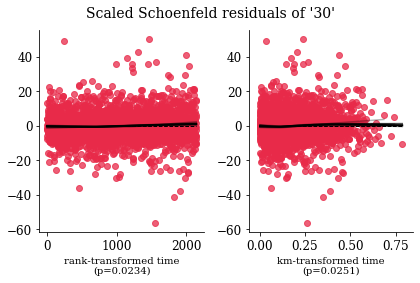

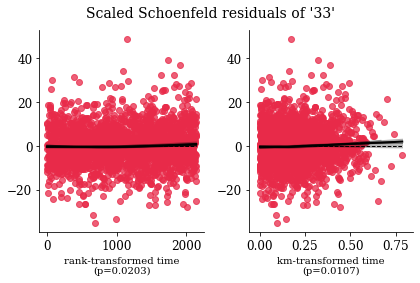

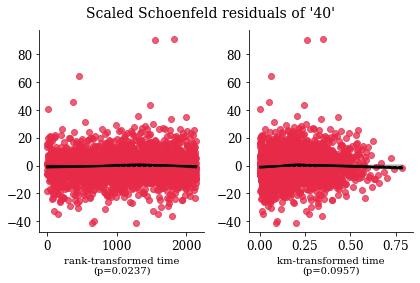

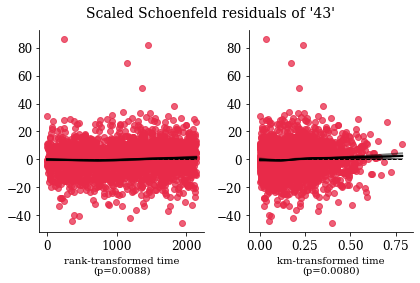

In [8]:
%%time

cph.check_assumptions(mRNA_data, p_value_threshold=0.05, show_plots=True)

In [12]:
last_point_num_in_output = 12
print('Null hypothesis (no violation of proportional hazards) rejected for:')
print(f'{last_point_num_in_output} out of {len(cph.params_)} input features')

Null hypothesis (no violation of proportional hazards) rejected for:
12 out of 50 input features


##  DNAm

In [9]:
%%time

modality = 'DNAm'

DNAm_data, cph = fit_omics_cph(modality)

Excluding 669 patient(s) missing all data.
Excluding 79 patient(s) missing all data.
Excluding 76 patient(s) missing all data.
Data modalities:
   DNAm

Dataset sizes (# patients):
   train: 8211
   val: 1030
   test: 1016

Batch size: 128

Load all patient data: 8211/8211    

Fitting CPH model on DNAm data...

CPU times: user 3min 44s, sys: 25.5 s, total: 4min 10s
Wall time: 3min 49s


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable '0' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable '0' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '0' using pd.cut, and then specify it in `strata=['0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable '1' failed the non-proportional test: p-value is 0.0002.

   Advice 1: the functional form of the variable '1' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the var


15. Variable '35' failed the non-proportional test: p-value is 0.0292.

   Advice 1: the functional form of the variable '35' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '35' using pd.cut, and then specify it in `strata=['35', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


16. Variable '36' failed the non-proportional test: p-value is 0.0156.

   Advice 1: the functional form of the variable '36' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning 

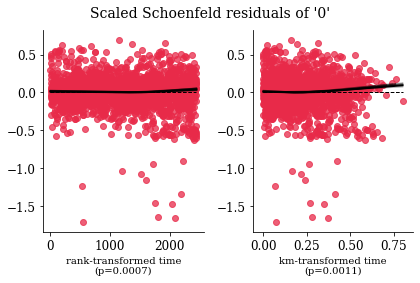

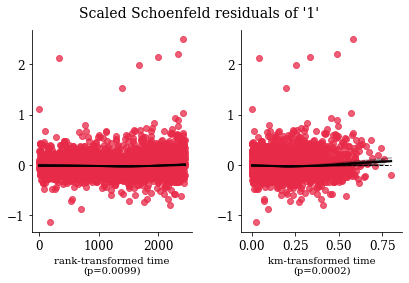

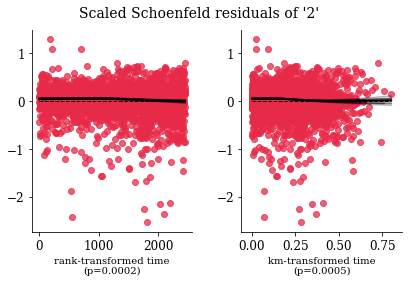

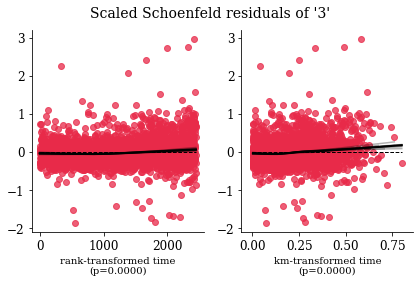

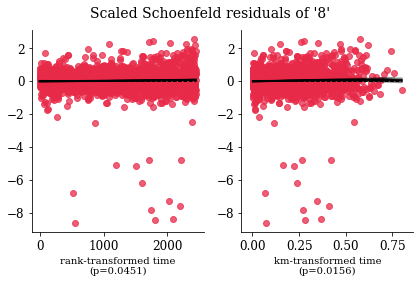

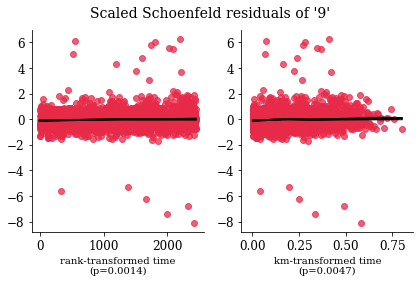

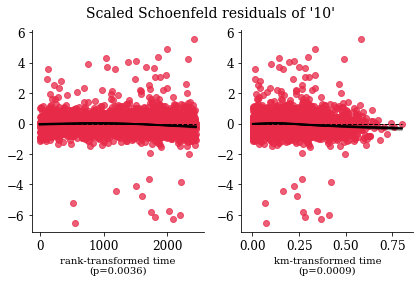

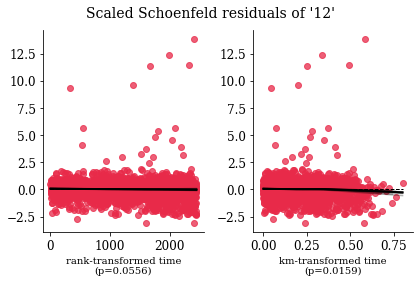

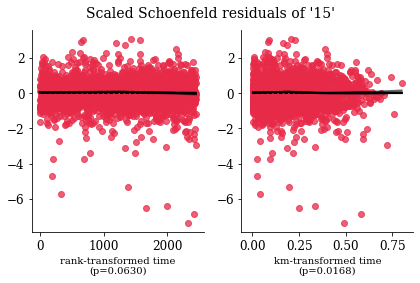

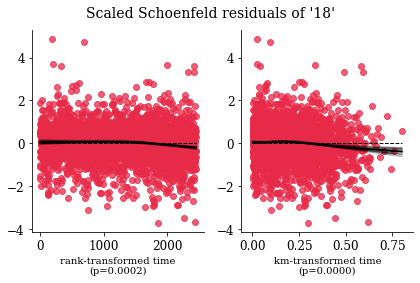

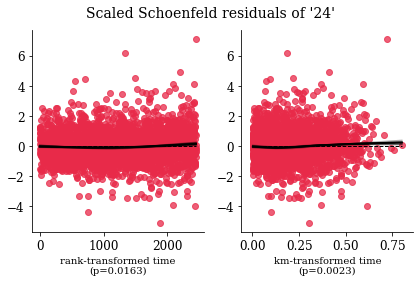

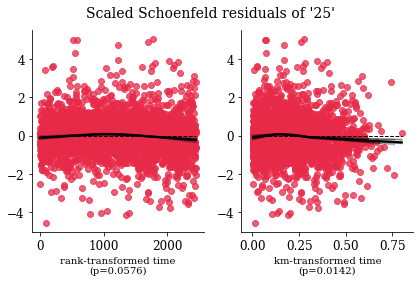

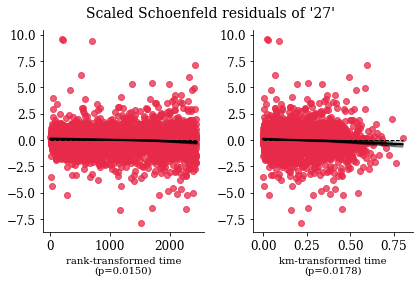

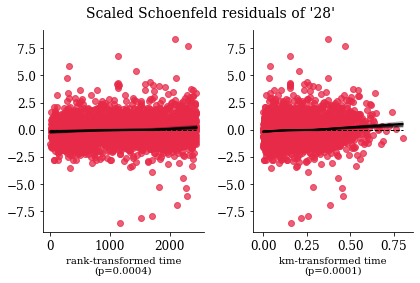

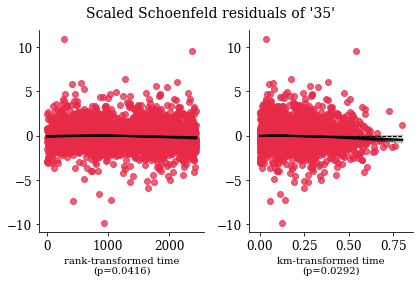

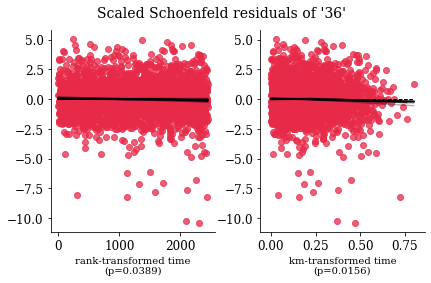

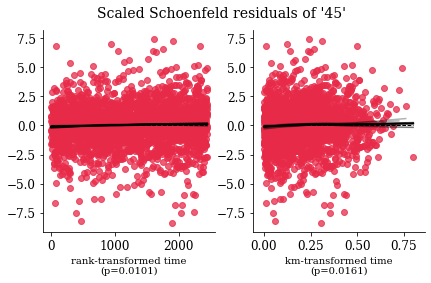

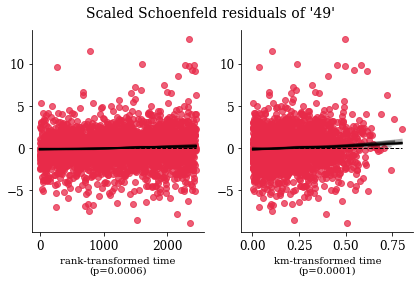

In [10]:
%%time

cph.check_assumptions(DNAm_data, p_value_threshold=0.05, show_plots=True)

In [ ]:
cph.

In [11]:
last_point_num_in_output = 18
print('Null hypothesis (no violation of proportional hazards) rejected for:')
print(f'{last_point_num_in_output} out of {len(cph.params_)} input features')

Null hypothesis (no violation of proportional hazards) rejected for:
18 out of 50 input features


##  miRNA

In [21]:
%%time

modality = 'miRNA'

miRNA_data, cph = fit_omics_cph(modality)

Excluding 1189 patient(s) missing all data.
Excluding 147 patient(s) missing all data.
Excluding 129 patient(s) missing all data.
Data modalities:
   miRNA

Dataset sizes (# patients):
   train: 7691
   val: 962
   test: 963

Batch size: 128

Load all patient data: 7691/7691    

Fitting CPH model on miRNA data...

CPU times: user 1min 59s, sys: 17.4 s, total: 2min 16s
Wall time: 2min 7s


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable '0' failed the non-proportional test: p-value is 0.0009.

   Advice 1: the functional form of the variable '0' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '0' using pd.cut, and then specify it in `strata=['0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable '1' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable '1' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the var

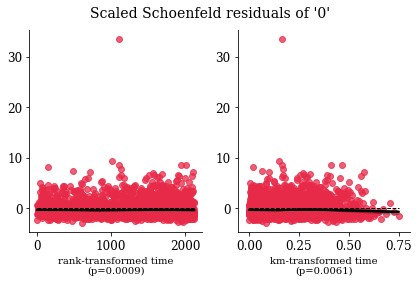

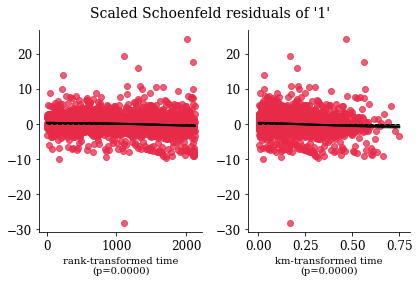

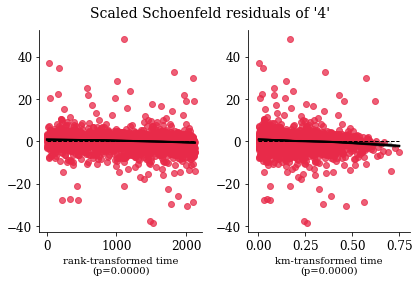

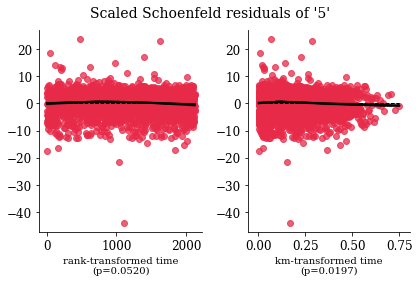

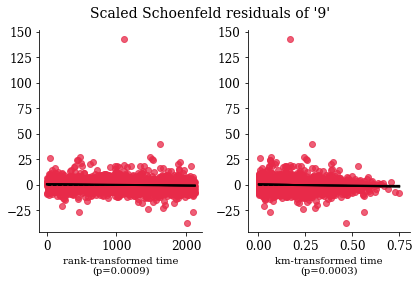

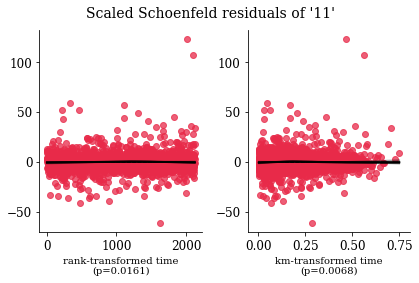

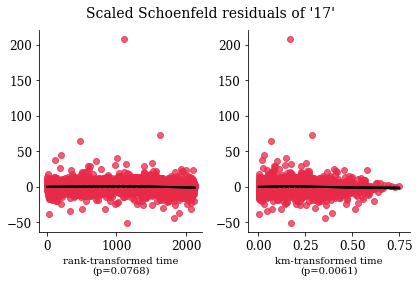

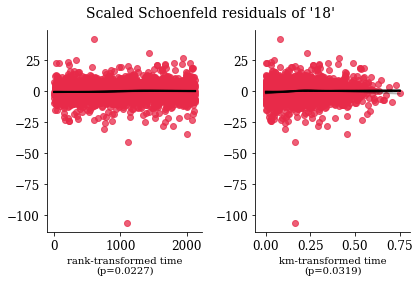

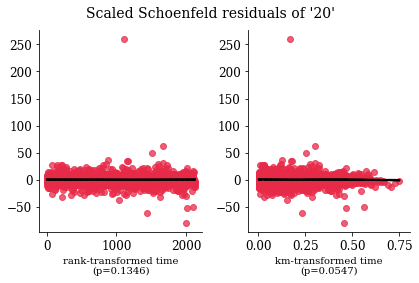

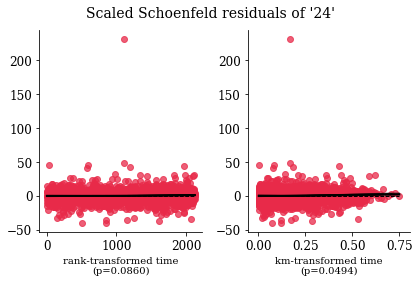

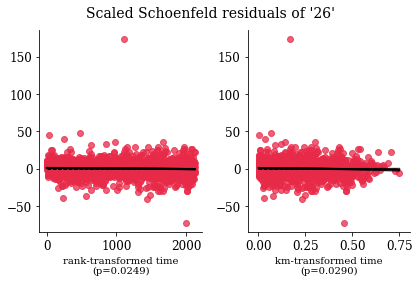

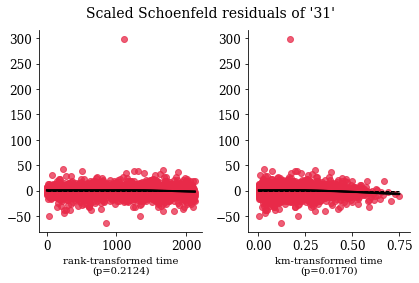

In [22]:
%%time

cph.check_assumptions(miRNA_data, p_value_threshold=0.05, show_plots=True)

In [23]:
last_point_num_in_output = 12
print('Null hypothesis (no violation of proportional hazards) rejected for:')
print(f'{last_point_num_in_output} out of {len(cph.params_)} input features')

Null hypothesis (no violation of proportional hazards) rejected for:
12 out of 50 input features


##  CNV

In [11]:
%%time

modality = 'CNV'

CNV_data, cph = fit_omics_cph(modality)

Excluding 615 patient(s) missing all data.
Excluding 72 patient(s) missing all data.
Excluding 69 patient(s) missing all data.
Data modalities:
   CNV

Dataset sizes (# patients):
   train: 8265
   val: 1037
   test: 1023

Batch size: 128

Load all patient data: 8265/8265    

Fitting CPH model on CNV data...



CPU times: user 2min 5s, sys: 19.5 s, total: 2min 25s
Wall time: 2min 15s


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.





1. Variable '0' failed the non-proportional test: p-value is 0.0176.

   Advice 1: the functional form of the variable '0' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable '0' using pd.cut, and then specify it in `strata=['0', ...]`
in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable '1' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable '1' might be incorrect. That is, there may be non-
linear terms missing. The proportional hazard test used is very sensitive to incorrect functional
forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the var

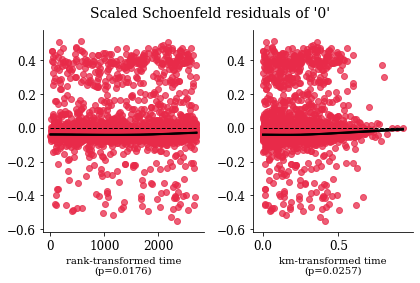

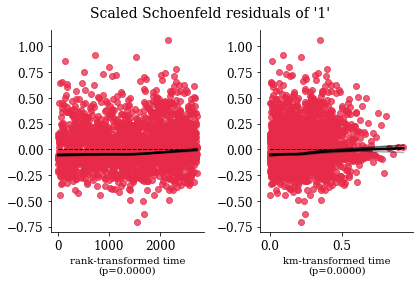

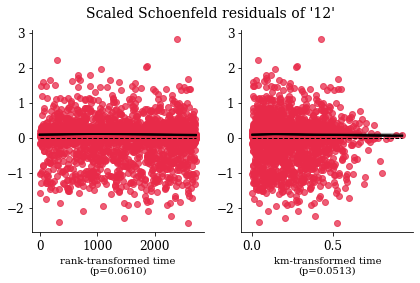

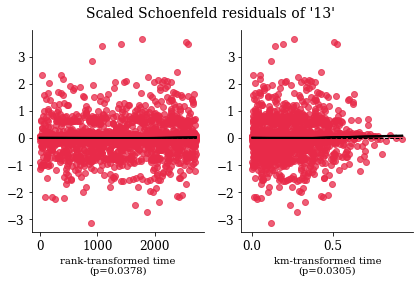

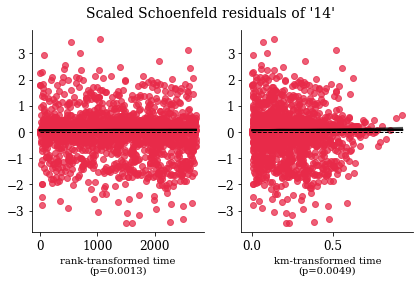

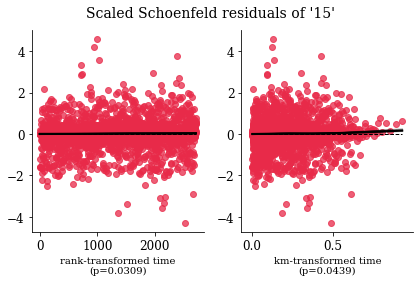

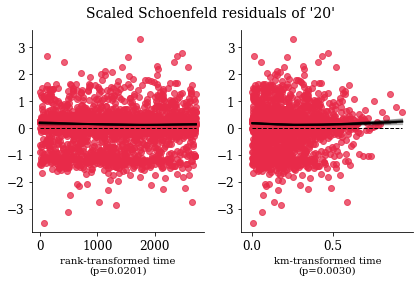

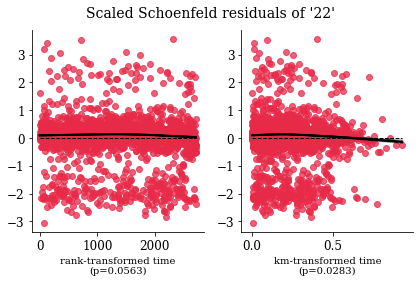

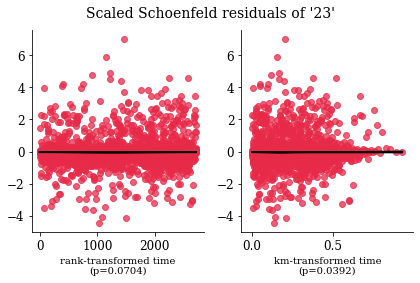

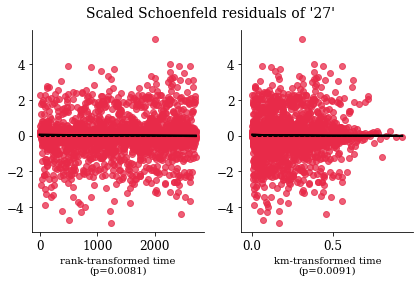

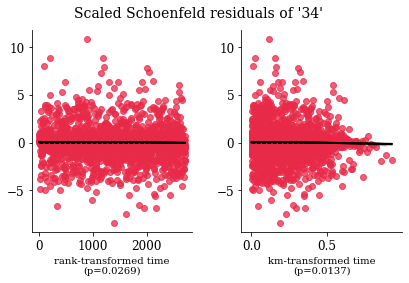

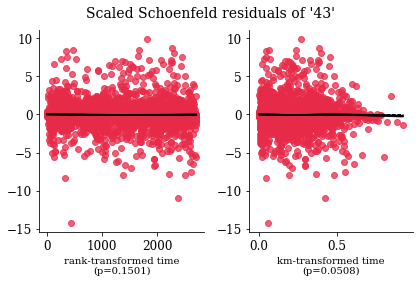

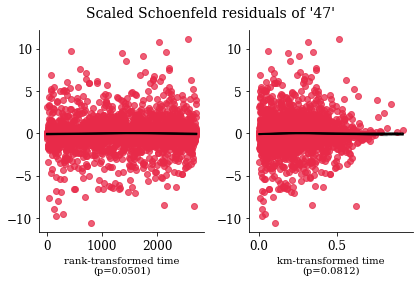

In [12]:
%%time

cph.check_assumptions(CNV_data, p_value_threshold=0.05, show_plots=True)

In [13]:
last_point_num_in_output = 13
print('Null hypothesis (no violation of proportional hazards) rejected for:')
print(f'{last_point_num_in_output} out of {len(cph.params_)} input features')

Null hypothesis (no violation of proportional hazards) rejected for:
13 out of 50 input features


# Watermark<a class='tocSkip'></a>

In [30]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

matplotlib 3.1.2
pandas     1.0.1
torch      1.4.0
numpy      1.18.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)